# Lab 7. Task 4

## Author: Konstantin Yakovlev


Visualize repeat-copy task using LSTM with schedules: from large length to small length and vice versa. Number of repeats is constant, set to 1. Visualize model performance wrt optimization iterations.


### Experimantal setup

1. As for the data, we used randomly generated sequences. Vcabulary size is 10.

2. We consider the following lengths: 5, 10, 12, 15.

3. We use piece-wise constant length scheduler.



In [1]:
! pip install -q jax jaxlib flax optax

In [2]:
import jax
from flax import linen as nn
from flax.training.train_state import TrainState
import optax
import jax.numpy as jnp
import numpy as np
from functools import partial

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [3]:
class LSTMModel(nn.Module):
    d_model: int = 50
    n_tokens: int = 10
    def setup(self):
        self.embedding = nn.Embed(self.d_model, self.n_tokens)
        lstm_layer = nn.scan(nn.OptimizedLSTMCell,
                               variable_broadcast="params",
                               split_rngs={"params": False},
                               in_axes=1, 
                               out_axes=1,
                               reverse=False)
        self.lstm = lstm_layer()
        self.dense = nn.Dense(self.n_tokens)
        
    @nn.compact    
    def __call__(self, x_batch):
        x = self.embedding(x_batch)
        
        carry, hidden = nn.OptimizedLSTMCell.initialize_carry(jax.random.PRNGKey(0),
                                                              batch_dims=(x_batch.shape[0],),
                                                              size=self.d_model)
        _, x = self.lstm((carry, hidden), x)
        x = self.dense(x)
       
        return nn.log_softmax(x, axis=-1)


@jax.jit
def lm_loss(logits, target):
    """
    logits (bs, seq_len, n_tokens)
    target (bs, seq_len, n_tokens)
    """
    return -(logits * target).mean()


@partial(jax.jit, static_argnums=2)
def loss_fn(logits, init_seq, seq_len):
    """
    :param logits: (bs, 2 * seq_len, hidden)
    :param init_seq: (bs, seq_len)
    """
    corr_logits = logits[:, -seq_len - 1: -1, :]
    target = jax.nn.one_hot(init_seq, logits.shape[-1])
    return lm_loss(corr_logits, target) 


def model_loss(apply_fn, params, init_seq):
    double_seq = jnp.concatenate([init_seq, init_seq], axis=-1)
    logits = apply_fn(params, double_seq)
    return loss_fn(logits, init_seq, init_seq.shape[-1])


In [4]:
def schedule_len(step, reverse=False):
    lengths = [5, 10, 12, 15]
    if reverse:
        lengths = lengths[::-1]
    if step <= 500:
        return lengths[0]
    elif step <= 1000:
        return lengths[1]
    elif step <= 1500:
        return lengths[2]
    else:
        return lengths[3]

def eval(apply_fn, params, eval_bs):
    d = {}
    for l in [15, 12, 10, 5]:
        tokens = jnp.asarray(np.random.randint(0, 10, size=(eval_bs, l)))
        loss = model_loss(apply_fn, params, tokens)
        d[l] = loss.item()
    return d


In [5]:

batch_size = 32
eval_bs = 70
losses = []
val_dicts = {'short_to_long': [], 'long_to_short': []}

for rev, key in zip([False, True], val_dicts.keys()):
    tokens = jnp.asarray(np.random.randint(0, 10, size=(16, 35))) # bs, seq_len
    model = LSTMModel()
    params = model.init({'params': jax.random.PRNGKey(0)}, tokens)


    state = TrainState.create(
        apply_fn=jax.jit(model.apply),
        params=params,
        tx=optax.adam(1e-3)
        )

    np.random.seed(0)

    for i in tqdm(range(2_000)):
        l = schedule_len(i, reverse=rev)
        tokens = jnp.asarray(np.random.randint(0, 10, size=(batch_size, l)))
        loss, grads = jax.value_and_grad(lambda p: model_loss(state.apply_fn, p, tokens))(state.params)
        losses.append(loss.item())
        state = state.apply_gradients(grads=grads)
        if i % 100 == 0 and i > 0:
            d_val = eval(state.apply_fn, state.params, eval_bs)
            val_dicts[key].append(d_val)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

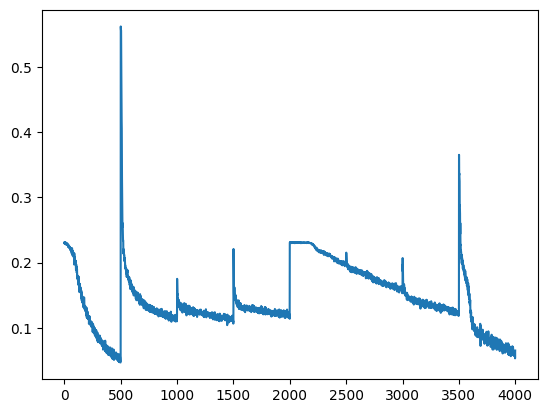

In [9]:
plt.plot(losses)
plt.show()

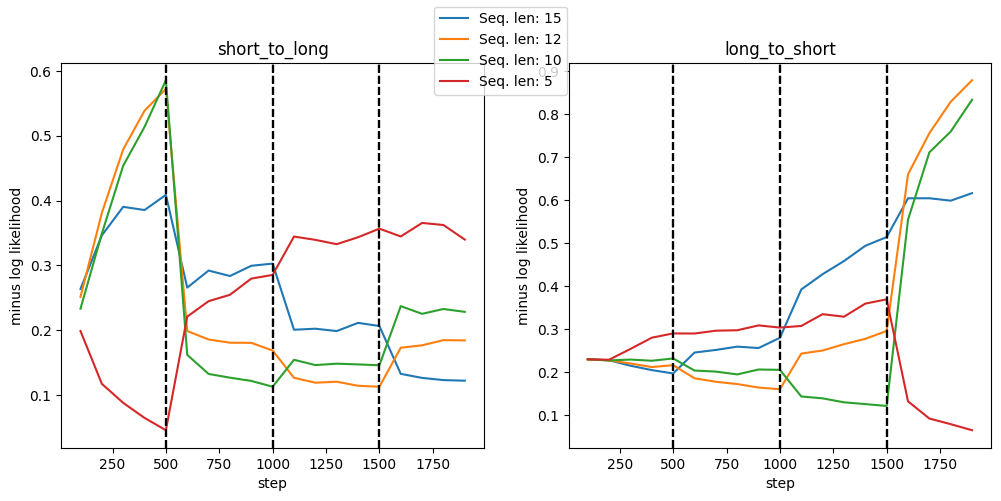

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for i, exp_key in enumerate(val_dicts):
    for key in val_dicts[exp_key][0]:
        values = [d[key] for d in val_dicts[exp_key]]
        axs[i].plot([i * 100 for i in range(1, len(values) + 1)], values, label=f'Seq. len: {key}')
        axs[i].set_title(exp_key)
        axs[i].set_xlabel('step')
        axs[i].set_ylabel('minus log likelihood')
        for switch in [500, 1000, 1500]:
            axs[i].axvline(x=switch, color='black', linestyle='--')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.show()

### Conclusion

1. We see that catastrophic forgetting is more evident in the training from long sequences to short sequences.

2. We also see that when training on a specific sequence length, negative log likelihood on close lengths also improves.
